# Kinetic Random Field Ising Model
This notebook implements the Kinetic Random Field Ising Model (KRFIM) with Glauber dynamics for a generic lattice.
The Hamiltonian of this model reads
$$
H = - \frac{1}{2}\sum_{i, j} J_{ij} s_i s_j - \sum_i f_i s_i - b \sum s_i
$$
where $s_i$ is the spin value at lattice point $i$, $J_{ij}$ is the exchange energy, $f_i$ is the random field, and $b$ is the external field. 


Glauber dynamics:
At each step select a spin at random. Calculate the energy difference with the splitted spin $\Delta E$, accept the change with probability
$$
p = \frac{1}{2}\left[1 - \tanh \left(\frac{\Delta E}{2 T}\right)\right]
$$

In general, at each field $b$ we discard a number of samples as they are not representative of the statical distribution. However, at zero temperature we can discard all but the last.


References:
- https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.70.3347
- https://www.sciencedirect.com/science/article/abs/pii/S0927025608002383
- Dissipative Phenomena in Condensed Matter, Sushanta Dattagupta and Sanjay Puri

In [49]:
# import matplotlib as mpl
import matplotlib.pyplot as plt
import numba
import numpy as np
# import scipy as sp
# from scipy import ndimage
from tqdm.notebook import tqdm
from matplotlib.gridspec import GridSpec

np.random.seed(0)

In [50]:
@numba.jit(nopython=True, cache=True)
def run_krfism_simulation(J, f, b, T, s_init, steps_number, save_samples=False):
    """
    Run kinetic random field Ising model with Glauber dynamics.

    Parameters:
        J: array_like
            Exchange coupling matrix, (Nsites, Nsites)
        f: array_like
            Random field (Nsites)
        b: float
            External magnetic field
        T:float
            Temperature
        s_init: array_like
            Initial configuration
        steps_number: int
            Number of steps
        save_samples: bool
            Whether to save samples or not

    Returns:
        m: array_like
            Average magnetization (Nsites)
        s: array_like
            Final configuration (Nsites) or samples (steps_number, Nsites) if save_samples=True
    """

    Nsites = J.shape[0]

    s = s_init
    m = np.zeros(steps_number)

    if save_samples:
        samples = np.zeros((steps_number, Nsites))
        samples[0] = s

    for n in range(steps_number):
        idx = np.random.randint(0, Nsites)
        Delta_E = 2 * (J[idx] @ s + f[idx] + b) * s[idx]

        if T == 0:
            if Delta_E < 0:
                s[idx] *= -1

        elif 1 / 2 * (1 - np.tanh(Delta_E / (2 * T))) > np.random.rand():
            s[idx] *= -1

        m[n] = np.mean(s)

        if save_samples:
            samples[n] = s

    if not save_samples:
        samples = s.reshape(1, -1)

    return m, samples


def hystersis_cycle_athermal(J, f, b_ax, steps_number):
    """
    Simulate random field Ising model on an hysteresis cycle at zero temperature.

        Parameters:
        J: array_like
            Exchange coupling matrix, (Nsites, Nsites)
        f: array_like
            Random field (Nsites)
        b_ax: array_like
            External magnetic field axis
        steps_number: int
            Number of steps
        save_samples: bool

    Returns:
        m_up: array_like
            Average magnetization (Nsites)
        s_up : array_like
            Final configuration (Nsites)
        m_down: array_like
            Average magnetization (Nsites)
        s_down : array_like
            Final configuration (Nsites)
    """

    b_N = len(b_ax)
    Nsites = J.shape[0]

    s_up = np.zeros((b_N, Nsites))
    m_up = np.zeros((b_N, steps_number))

    s_down = np.zeros((b_N, Nsites))
    m_down = np.zeros((b_N, steps_number))

    # Up ramp
    s_init = -np.ones(Nsites)
    for b_idx in range(b_N):
        b = b_ax[b_idx]
        m_up[b_idx], s_up[b_idx] = run_krfism_simulation(
            J, f, b, T=0, s_init=s_init, steps_number=steps_number, save_samples=False
        )
        s_init = s_up[b_idx]

    # Down ramp
    s_init = s_up[-1]
    for b_idx in range(b_N - 1, -1, -1):
        b = b_ax[b_idx]
        m_down[b_idx], s_down[b_idx] = run_krfism_simulation(
            J, f, b, T=0, s_init=s_init, steps_number=steps_number, save_samples=False
        )
        s_init = s_down[b_idx]

    return m_up, s_up, m_down, s_down


def disorder_averged_hysteresis_cycle_athermal(J, f_gf, f_sn, b_ax, steps_number):
    """
    Simulate random field Ising model on an hysteresis cycle at zero temperature for many disorder realizations.

        Parameters:
        J: array_like
            Exchange coupling matrix, (Nsites, Nsites)
        f_gf: array_like
            Random field generating function
        f_sn: int
            Number of realizations
        b_ax: array_like
            External magnetic field axis
        steps_number: int
            Number of steps
        save_samples: bool

    Returns:
        m_up_s: array_like
            Average magnetization (Nsites)
        m_down_s: array_like
            Average magnetization (Nsites)
    """

    b_N = len(b_ax)
    m_up_s = np.zeros((f_sn, b_N))
    m_down_s = np.zeros((f_sn, b_N))

    for i in tqdm(range(f_sn)):
        f = f_gf()
        m_up, s_up, m_down, s_down = hystersis_cycle_athermal(J, f, b_ax, steps_number)

        m_up_s[i] = m_up[:, -1]
        m_down_s[i] = m_down[:, -1]

    return m_up_s, m_down_s

In [51]:
# Domain grid
Nx, Ny = 10, 10
Nsites = Nx * Ny

# Set the exchange energy
J = np.diag(np.ones(Nx - 1), k=1) + np.diag(np.ones(Nx - 1), k=-1)
J = np.kron(J, np.eye(Nx)) + np.kron(np.eye(Nx), J)
#J = np.zeros((Nsites, Nsites))
#J += np.diag(np.ones(Nsites - 1), k=1) + np.diag(np.ones(Nsites - 1), k=-1)
#J += np.diag(np.ones(Nsites - Nx), k=Nx) + np.diag(np.ones(Nsites - Nx), k=-Nx)

# Temperature
T = 0

# Generating function of the random field
def f_gf():
    R = 1.
    return np.random.randn(Nsites) * R


# Magnetic field axis
b_N = 101
b_ax = np.linspace(-3, 3, b_N)

# Number of steps per cycle
steps_number = 4000

# Single cycle

In [52]:
f = f_gf()

In [53]:
m_up, s_up, m_down, s_down = hystersis_cycle_athermal(J, f, b_ax, steps_number)

In [54]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
# ax1.imshow(s_up[52].reshape(Nx, Ny), vmin=0, vmax=1)
# ax2.imshow(s_up[53].reshape(Nx, Ny), vmin=0, vmax=1)
# ax3.imshow(s_up[54].reshape(Nx, Ny), vmin=0, vmax=1)
# ax4.imshow(s_up[55].reshape(Nx, Ny), vmin=0, vmax=1)

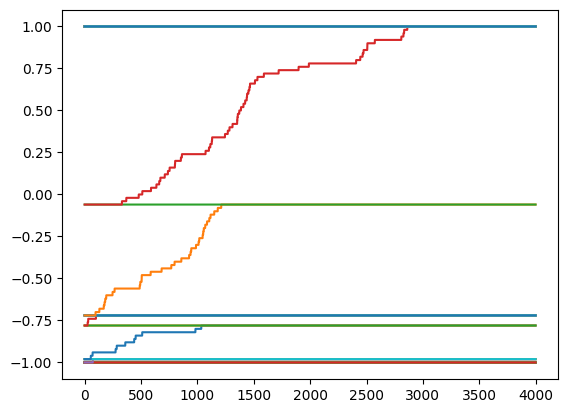

In [55]:
# Check convergence
plt.plot(range(steps_number), m_up.T);

Text(0, 0.5, '$m/M_s$')

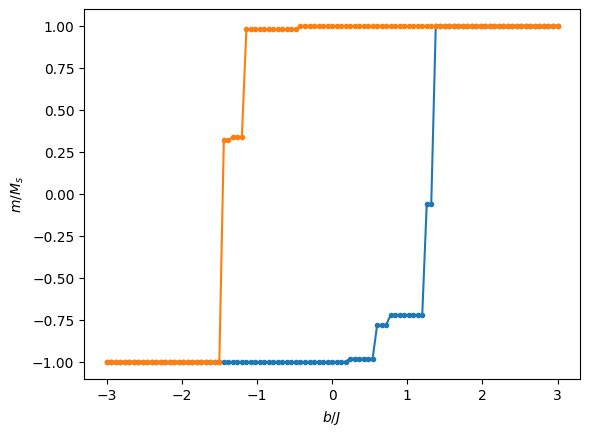

In [56]:
fig, ax = plt.subplots()
ax.plot(b_ax, m_up[:, -1], ".-")
ax.plot(b_ax, m_down[:, -1], ".-")
ax.set_xlabel(r"$b/J$")
ax.set_ylabel(r"$m/M_s$")

# Disorder average

In [57]:
f_sn = 19 # 300  # Number of realization
m_up_s, m_down_s = disorder_averged_hysteresis_cycle_athermal(
    J, f_gf, f_sn, b_ax, steps_number
)

  0%|          | 0/19 [00:00<?, ?it/s]

In [58]:
mc_0_pi = 0.7
mc_pi_N = 0.9

In [59]:
m_up_s = np.append(m_up_s, m_up[:, [-1]].T, axis=0)
m_down_s = np.append(m_down_s, m_down[:, [-1]].T, axis=0)

m_up_mean = m_up_s.mean(axis=0)
m_down_mean = m_down_s.mean(axis=0)

# bins = [-1.1, -mc_pi_N, -mc_0_pi, mc_0_pi, mc_pi_N, 1.1]  # This one is for a 5 column plot
bins = 20

m_up_hist = np.histogram(m_up_s.flatten(), density = True, bins=bins)
m_down_hist = np.histogram(m_down_s.flatten(), density = True, bins=bins)

## Paper plot

In [60]:
bar_colors = ([['C7'] * 1 , ['C0'] * 2, ['C3'] * 14, ['C0'] * 2, ['C7'] * 1])
bar_colors = [item for sublist in bar_colors for item in sublist]

In [61]:
middle_plots_idx = [67, 69, 71, 73]

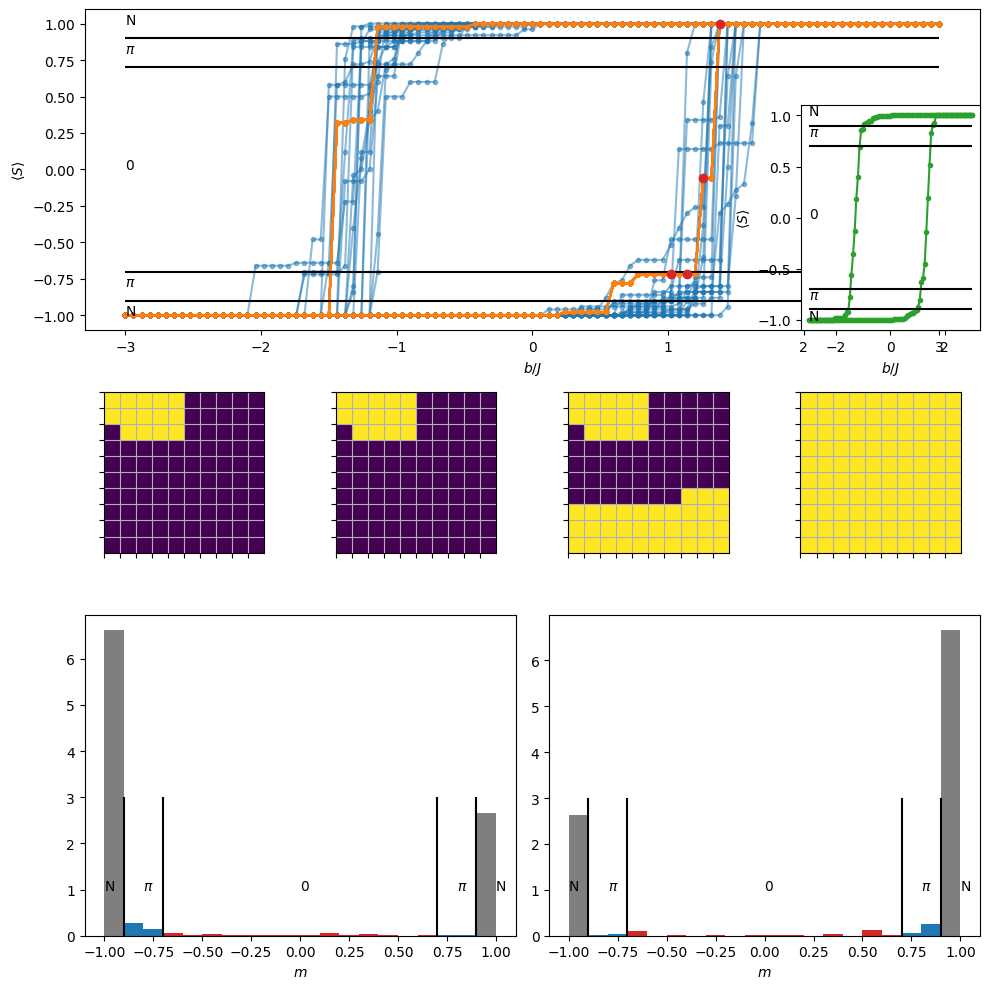

In [62]:
fig = plt.figure( figsize = (10, 10))

gs = GridSpec(3, 4, width_ratios=[1, 1, 1, 1], height_ratios=[2, 1, 2])

ax_t = fig.add_subplot(gs[0, :])

ax_m1 = fig.add_subplot(gs[1, 0])
ax_m2 = fig.add_subplot(gs[1, 1])
ax_m3 = fig.add_subplot(gs[1, 2])
ax_m4 = fig.add_subplot(gs[1, 3])

ax_b1 = fig.add_subplot(gs[2, :2])
ax_b2 = fig.add_subplot(gs[2, 2:])

##### TOP

# We show only 20 curves, otherwise it gets too crowded
for i in range(19):
    ax_t.plot(b_ax, m_up_s[i, :], ".-", color="C0", alpha=0.5)
    ax_t.plot(b_ax, m_down_s[i, :], ".-", color="C0", alpha=0.5)

# Orange curve
    ax_t.plot(b_ax, m_up_s[-1, :], ".-", color='C1')
    ax_t.plot(b_ax, m_down_s[-1, :], ".-", color='C1')

ax_t.set_xlabel(r"$b / J$")
ax_t.set_ylabel(r"$\langle S \rangle $")

ax_t.hlines([mc_pi_N, mc_0_pi, -mc_0_pi, -mc_pi_N], -3, 3, colors="k")

ax_t.text(-3, 1.0, "N")
ax_t.text(-3, 0.8, "$\pi$")
ax_t.text(-3, 0.0, "0")
ax_t.text(-3, -0.8, "$\pi$")
ax_t.text(-3, -1.0, "N")


ax_t.scatter(b_ax[middle_plots_idx], m_up[:, -1][middle_plots_idx], color='C3', zorder=20)

#### INSET

axins = ax_t.inset_axes((0.8, 0, 0.2, 0.7))
axins.plot(b_ax, m_up_mean, ".-", color="C2")
axins.plot(b_ax, m_down_mean, ".-", color="C2")
axins.set_xlabel(r"$b / J$")
axins.set_ylabel(r"$\langle S \rangle$")

axins.hlines([mc_pi_N, mc_0_pi, -mc_0_pi, -mc_pi_N], -3, 3, colors="k")

axins.text(-3, 1.0, "N")
axins.text(-3, 0.8, "$\pi$")
axins.text(-3, 0.0, "0")
axins.text(-3, -0.8, "$\pi$")
axins.text(-3, -1.0, "N")

##### MIDDLE

ax_m1.imshow(s_up[middle_plots_idx[0]-1].reshape(Nx, Ny), vmin=0, vmax=1)
ax_m2.imshow(s_up[middle_plots_idx[1]-1].reshape(Nx, Ny), vmin=0, vmax=1)
ax_m3.imshow(s_up[middle_plots_idx[2]-1].reshape(Nx, Ny), vmin=0, vmax=1)
ax_m4.imshow(s_up[middle_plots_idx[3]-1].reshape(Nx, Ny), vmin=0, vmax=1)

ax_m1.set_xticks(np.arange(10)-0.5, labels=[])
ax_m2.set_xticks(np.arange(10)-0.5, labels=[])
ax_m3.set_xticks(np.arange(10)-0.5, labels=[])
ax_m4.set_xticks(np.arange(10)-0.5, labels=[])

ax_m1.set_yticks(np.arange(10)-0.5, labels=[])
ax_m2.set_yticks(np.arange(10)-0.5, labels=[])
ax_m3.set_yticks(np.arange(10)-0.5, labels=[])
ax_m4.set_yticks(np.arange(10)-0.5, labels=[])

ax_m1.grid(visible=True, which='major', axis='both')
ax_m2.grid(visible=True, which='major', axis='both')
ax_m3.grid(visible=True, which='major', axis='both')
ax_m4.grid(visible=True, which='major', axis='both')

##### BOTTOM

# bins = [-1.1, -mc_pi_N, -mc_0_pi, mc_0_pi, mc_pi_N, 1.1]
bins = 30

ax_b1.bar(m_up_hist[1][:-1], m_up_hist[0], width=0.1, align='edge', color = bar_colors)
ax_b1.vlines([mc_pi_N, mc_0_pi, -mc_0_pi, -mc_pi_N], 0, 3, colors="k")

ax_b1.text(1.0, 1, "N")
ax_b1.text(0.8, 1, "$\pi$")
ax_b1.text(0.0, 1, "0")
ax_b1.text(-0.8, 1, "$\pi$")
ax_b1.text(-1.0, 1, "N")
ax_b1.set_xlabel("$m$")

ax_b2.bar(m_down_hist[1][:-1], m_down_hist[0], width=0.1, align='edge', color = bar_colors)
ax_b2.vlines([mc_pi_N, mc_0_pi, -mc_0_pi, -mc_pi_N], 0, 3, colors="k")

ax_b2.text(1.0, 1, "N")
ax_b2.text(0.8, 1, "$\pi$")
ax_b2.text(0.0, 1, "0")
ax_b2.text(-0.8, 1, "$\pi$")
ax_b2.text(-1.0, 1, "N")
ax_b2.set_xlabel("$m$")

gs.tight_layout(fig)

plt.savefig('ising_figure.pdf')

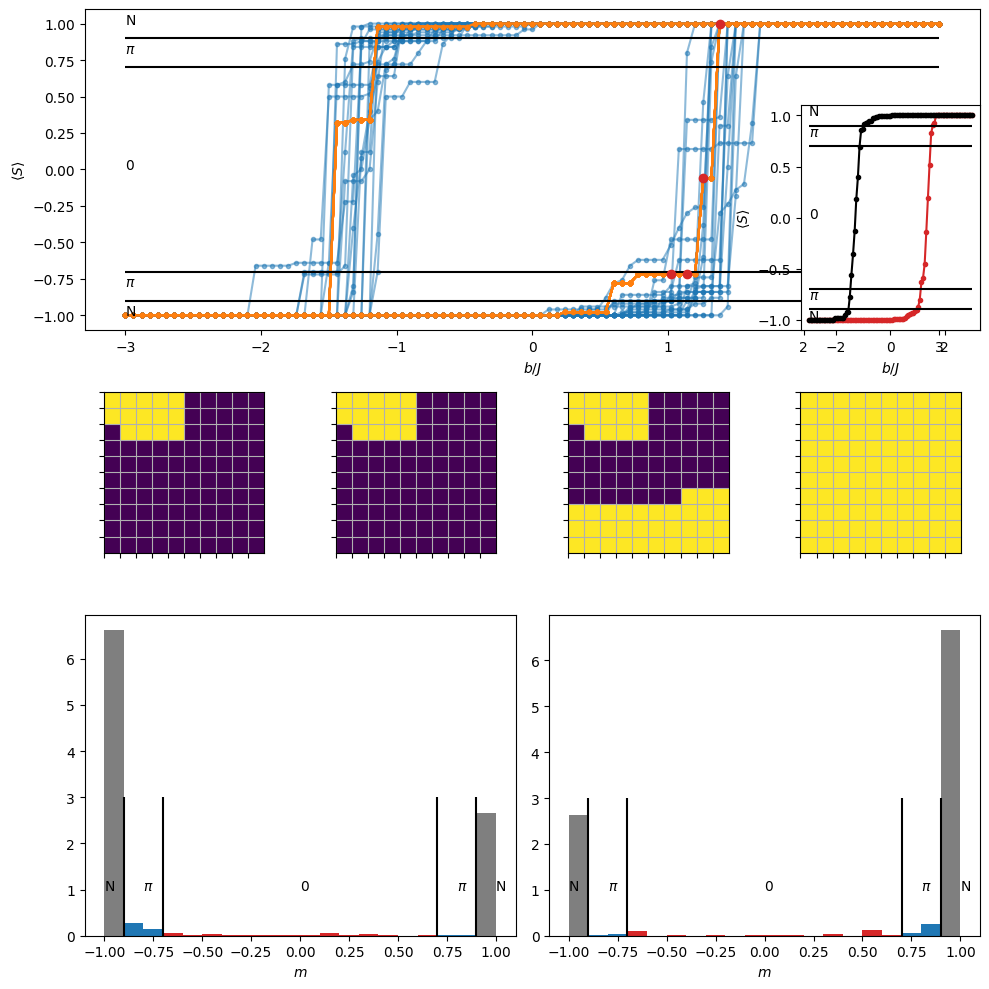

In [63]:
fig = plt.figure( figsize = (10, 10))

gs = GridSpec(3, 4, width_ratios=[1, 1, 1, 1], height_ratios=[2, 1, 2])

ax_t = fig.add_subplot(gs[0, :])

ax_m1 = fig.add_subplot(gs[1, 0])
ax_m2 = fig.add_subplot(gs[1, 1])
ax_m3 = fig.add_subplot(gs[1, 2])
ax_m4 = fig.add_subplot(gs[1, 3])

ax_b1 = fig.add_subplot(gs[2, :2])
ax_b2 = fig.add_subplot(gs[2, 2:])

##### TOP

# We show only 20 curves, otherwise it gets too crowded
for i in range(19):
    ax_t.plot(b_ax, m_up_s[i, :], ".-", color="C0", alpha=0.5)
    ax_t.plot(b_ax, m_down_s[i, :], ".-", color="C0", alpha=0.5)

# Orange curve
    ax_t.plot(b_ax, m_up_s[-1, :], ".-", color='C1')
    ax_t.plot(b_ax, m_down_s[-1, :], ".-", color='C1')

ax_t.set_xlabel(r"$b / J$")
ax_t.set_ylabel(r"$\langle S \rangle $")

ax_t.hlines([mc_pi_N, mc_0_pi, -mc_0_pi, -mc_pi_N], -3, 3, colors="k")

ax_t.text(-3, 1.0, "N")
ax_t.text(-3, 0.8, "$\pi$")
ax_t.text(-3, 0.0, "0")
ax_t.text(-3, -0.8, "$\pi$")
ax_t.text(-3, -1.0, "N")


ax_t.scatter(b_ax[middle_plots_idx], m_up[:, -1][middle_plots_idx], color='C3', zorder=20)

#### INSET

axins = ax_t.inset_axes((0.8, 0, 0.2, 0.7))
axins.plot(b_ax, m_up_mean, ".-", color="C3")
axins.plot(b_ax, m_down_mean, ".-", color="k")
axins.set_xlabel(r"$b / J$")
axins.set_ylabel(r"$\langle S \rangle$")

axins.hlines([mc_pi_N, mc_0_pi, -mc_0_pi, -mc_pi_N], -3, 3, colors="k")

axins.text(-3, 1.0, "N")
axins.text(-3, 0.8, "$\pi$")
axins.text(-3, 0.0, "0")
axins.text(-3, -0.8, "$\pi$")
axins.text(-3, -1.0, "N")

##### MIDDLE

ax_m1.imshow(s_up[middle_plots_idx[0]-1].reshape(Nx, Ny), vmin=0, vmax=1)
ax_m2.imshow(s_up[middle_plots_idx[1]-1].reshape(Nx, Ny), vmin=0, vmax=1)
ax_m3.imshow(s_up[middle_plots_idx[2]-1].reshape(Nx, Ny), vmin=0, vmax=1)
ax_m4.imshow(s_up[middle_plots_idx[3]-1].reshape(Nx, Ny), vmin=0, vmax=1)

ax_m1.set_xticks(np.arange(10)-0.5, labels=[])
ax_m2.set_xticks(np.arange(10)-0.5, labels=[])
ax_m3.set_xticks(np.arange(10)-0.5, labels=[])
ax_m4.set_xticks(np.arange(10)-0.5, labels=[])

ax_m1.set_yticks(np.arange(10)-0.5, labels=[])
ax_m2.set_yticks(np.arange(10)-0.5, labels=[])
ax_m3.set_yticks(np.arange(10)-0.5, labels=[])
ax_m4.set_yticks(np.arange(10)-0.5, labels=[])

ax_m1.grid(visible=True, which='major', axis='both')
ax_m2.grid(visible=True, which='major', axis='both')
ax_m3.grid(visible=True, which='major', axis='both')
ax_m4.grid(visible=True, which='major', axis='both')

##### BOTTOM

# bins = [-1.1, -mc_pi_N, -mc_0_pi, mc_0_pi, mc_pi_N, 1.1]
bins = 30

ax_b1.bar(m_up_hist[1][:-1], m_up_hist[0], width=0.1, align='edge', color = bar_colors)
ax_b1.vlines([mc_pi_N, mc_0_pi, -mc_0_pi, -mc_pi_N], 0, 3, colors="k")

ax_b1.text(1.0, 1, "N")
ax_b1.text(0.8, 1, "$\pi$")
ax_b1.text(0.0, 1, "0")
ax_b1.text(-0.8, 1, "$\pi$")
ax_b1.text(-1.0, 1, "N")
ax_b1.set_xlabel("$m$")

ax_b2.bar(m_down_hist[1][:-1], m_down_hist[0], width=0.1, align='edge', color = bar_colors)
ax_b2.vlines([mc_pi_N, mc_0_pi, -mc_0_pi, -mc_pi_N], 0, 3, colors="k")

ax_b2.text(1.0, 1, "N")
ax_b2.text(0.8, 1, "$\pi$")
ax_b2.text(0.0, 1, "0")
ax_b2.text(-0.8, 1, "$\pi$")
ax_b2.text(-1.0, 1, "N")
ax_b2.set_xlabel("$m$")

gs.tight_layout(fig)

plt.savefig('ising_figure.pdf')

In [64]:
bins=20
hist=np.histogram([-1,1,-1,1,0.9,0.89,0.91], density = True, bins=bins)


<BarContainer object of 20 artists>

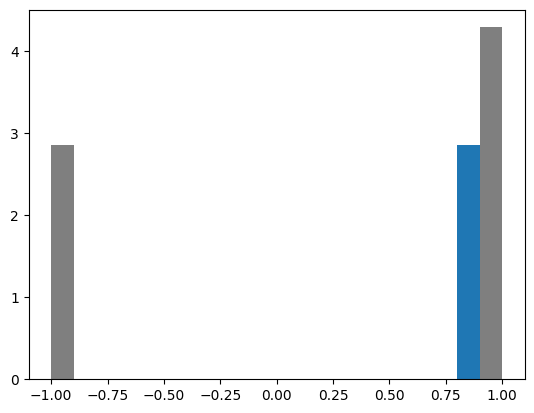

In [65]:
plt.bar(hist[1][:-1], hist[0], width=0.1, align='edge', color = bar_colors)


In [66]:
hist

(array([2.85714286, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 2.85714286, 4.28571429]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))

In [67]:
2.85714286*2+4.28571429

10.00000001

In [68]:
10/7*3

4.285714285714286

In [69]:
J

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

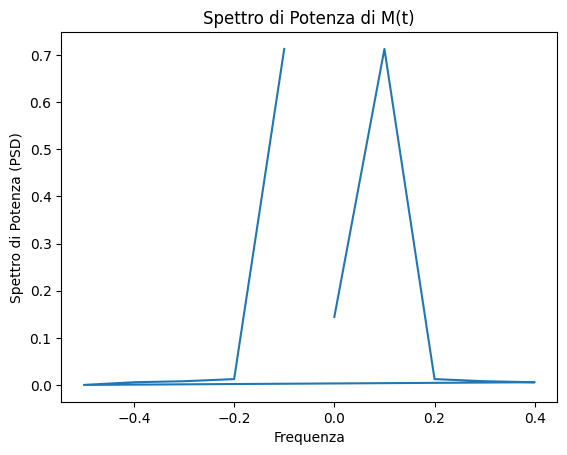

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Serie temporale della magnetizzazione (esempio di dati simulati)
M_t = np.array([0.1, 0.15, 0.2, 0.18, 0.1, -0.05, -0.1, -0.15, -0.1, 0.05])

# Calcola la trasformata di Fourier
F_k = np.fft.fft(M_t)

# Calcola le frequenze associate
frequenze = np.fft.fftfreq(len(M_t))

# Calcola lo spettro di potenza (PSD)
PSD = np.abs(F_k) ** 2

# Visualizza lo spettro di potenza
plt.plot(frequenze, PSD)
plt.xlabel('Frequenza')
plt.ylabel('Spettro di Potenza (PSD)')
plt.title('Spettro di Potenza di M(t)')
plt.show()

In [71]:
import numpy as np
import scipy.io.wavfile as wavfile
from scipy.fft import ifft
import matplotlib.pyplot as plt

# Genera una serie temporale di esempio o usa i dati simulati precedentemente
M_t = np.array([0.1, 0.15, 0.2, 0.18, 0.1, -0.05, -0.1, -0.15, -0.1, 0.05])

# Calcola la trasformata di Fourier
F_k = np.fft.fft(M_t)

# Calcola la PSD (Power Spectral Density)
PSD = np.abs(F_k) ** 2

# Ricostruisci il segnale temporale con la trasformata inversa
M_t_reconstructed = ifft(F_k).real

# Normalizza il segnale tra -1 e 1 per adattarlo al formato audio
M_t_reconstructed = M_t_reconstructed / np.max(np.abs(M_t_reconstructed))

# Imposta la frequenza di campionamento, ad esempio 44100 Hz per il file audio
sample_rate = 44100

# Salva il segnale normalizzato come file WAV
wavfile.write("output.wav", sample_rate, M_t_reconstructed.astype(np.float32))

print("File audio 'output.wav' generato con successo.")

File audio 'output.wav' generato con successo.
